try knn and iterative imputer techniques on limited dataset

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [309]:
data = pd.read_csv("selected_features_data")

In [310]:
# y_label = ["lab_malaria_any_d0"]
y_label = ["dxlab_malaria_hi"]

In [311]:
X_labels

['dem_child_house',
 'symp_abdopain',
 'dem_sex',
 'symp_pharyngitis',
 'symp_feveronly',
 'symp_fever_dur',
 'signv_hr1_d0',
 'signv_temp_d0',
 'date_d30_01',
 'sign_skininf',
 'signv_muac_d0',
 'sign_respdistress',
 'symp_loa',
 'date_season_meteo',
 'days_of_fever',
 'dem_age_int',
 'symp_diarrhea',
 'signv_waz_d0',
 'symp_skin_any',
 'signv_rr1_d0',
 'dem_mat_educat',
 'sign_danger',
 'symp_vomit',
 'symp_cough']

In [271]:
X_labels=list(set(data.columns)-set(y_label))
data.dropna(subset=y_label, inplace = True)

X = data[X_labels]
y = np.array(data[y_label]).ravel()

In [272]:
def get_column_type(data, n_cont_threshold=6):
    types = pd.DataFrame([[data.columns[idx], data[val].nunique()] for idx, val in enumerate(data)],
                        columns = ["features", "unique_values"])
    numerical = list(types[types["unique_values"]>n_cont_threshold]["features"])
    categorical = list(types[(types["unique_values"]<n_cont_threshold)&(types["unique_values"]>2)]["features"])
    binary = list(types[types["unique_values"]==2]["features"])
    return numerical, categorical, binary


numerical, categorical, binary = get_column_type(data[X_labels])

In [273]:
import sklearn
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, Binarizer, LabelEncoder, MinMaxScaler

from pprint import pprint
from time import time


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC


# pre-process EXCEPT over sampling

In [363]:
numX = X[numerical]
catX = X[categorical]
binX = X[binary]


# si = KNNImputer(n_neighbors=3)
si = SimpleImputer(strategy="mean")

mms = MinMaxScaler()
ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


for i in categorical:
    data[i] = data[i].astype("category")

catX_pre = pd.get_dummies(data[categorical])

binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)


cols=list(numX_pre.columns) +list(catX_pre.columns)+ list(binX_pre.columns)
X_pre = pd.DataFrame(np.column_stack((numX_pre, catX_pre, binX_pre)),columns = cols)

X_pre_labels=list(set(X_pre.columns))

le=LabelEncoder()

y_pre = le.fit_transform(y)

In [364]:
from imblearn.over_sampling import *
from imblearn.under_sampling import *

In [365]:
train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)

In [366]:
ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
rus = RandomUnderSampler(sampling_strategy="majority", random_state=0)
smote = SMOTE(sampling_strategy = "minority", random_state=0)
oss = OneSidedSelection(random_state=0)
tomek = TomekLinks(sampling_strategy="majority")


train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)

train_X_oss, train_y_oss = smote.fit_sample(train_X, train_y)
train_X_tomek, train_y_tomek = tomek.fit_sample(train_X, train_y)



In [367]:
from sklearn.ensemble import RandomForestClassifier
# classifier__max_depth 5
# classifier__max_features auto
# classifier__min_samples_leaf 4
# classifier__n_estimators 300

In [368]:
rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                            min_samples_leaf=3, n_estimators=150).fit(train_X, np.ravel(train_y))
rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                               min_samples_leaf=3, n_estimators=150).fit(train_X_ros, np.ravel(train_y_ros))

rf_oss = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                               min_samples_leaf=3, n_estimators=150).fit(train_X_oss, np.ravel(train_y_oss))

rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                 min_samples_leaf=3, n_estimators=150).fit(train_X_smote, np.ravel(train_y_smote))


rf_tomek = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                               min_samples_leaf=3, n_estimators=150).fit(train_X_tomek, np.ravel(train_y_tomek))

rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                               min_samples_leaf=3, n_estimators=150).fit(train_X_rus, np.ravel(train_y_rus))

In [369]:
names = ["normal", "ros", "oss","smote","tomek", "rus"]
for idx, val in enumerate([rf, rf_ros, rf_oss, rf_smote, rf_tomek, rf_rus]):
    
    preds = val.predict(val_X)
    preds_probas = val.predict_proba(val_X)[:,1]

    accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
    precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
    recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
    roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
    
    print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n".format(str(val.__class__.__name__)+" "+names[idx],
         accuracy, precision, recall, roc_auc))
    
    
    
    tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
    spec = tn/(tn+fp)
    sens = tp/(tp+fn)

    print("specificity {}\n sensitivity {}\n\n\n".format(spec, sens))

RandomForestClassifier normal
acc 0.9323308270676691
 precision 1.0 
 recall 0.01818181818181818 
 rocauc 0.509090909090909

specificity 1.0
 sensitivity 0.01818181818181818



RandomForestClassifier ros
acc 0.8020050125313283
 precision 0.19883040935672514 
 recall 0.6181818181818182 
 rocauc 0.716897100208002

specificity 0.8156123822341858
 sensitivity 0.6181818181818182



RandomForestClassifier oss
acc 0.8508771929824561
 precision 0.25384615384615383 
 recall 0.6 
 rocauc 0.7347240915208614

specificity 0.8694481830417228
 sensitivity 0.6



RandomForestClassifier smote
acc 0.8508771929824561
 precision 0.25384615384615383 
 recall 0.6 
 rocauc 0.7347240915208614

specificity 0.8694481830417228
 sensitivity 0.6



RandomForestClassifier tomek
acc 0.9335839598997494
 precision 1.0 
 recall 0.03636363636363636 
 rocauc 0.5181818181818182

specificity 1.0
 sensitivity 0.03636363636363636



RandomForestClassifier rus
acc 0.7055137844611529
 precision 0.15384615384615385 
 recall 0.7

In [290]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=1000, random_state=0)
clf.fit(train_X, train_y)
preds = clf.predict(val_X)
preds_probas = clf.predict_proba(val_X)[:,1]
accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
# roc_auc = sklearn.metrics.roc_auc_score(y_pred = preds, y_true = val_y)

In [439]:
pipeline_RF = Pipeline(steps = [
    ("classifier", RandomForestClassifier(random_state=0, bootstrap = True))
])




parameters_RF= {
    "classifier__n_estimators":(100, 125, 150, 175, 200),
    "classifier__max_depth":(4, 5, 6,),
    "classifier__max_features":("auto","sqrt","log2"),
    "classifier__min_samples_leaf":(2, 3, 4, 5, 6)
#     "classifier__oob_score":(False, True)
}
   
# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [494]:
grid_search_SVC.best_score_

0.8909280097511945

In [391]:
def run_grid_search_cv(pipeline, parameters, X_train, y_train, scoring_method, cv=5, njobs=1, verbose=1):
    
#     cv = RepeatedStratifiedKFold(n_splits=cvsplits, n_repeats=10, random_state=0)
    grid_search = GridSearchCV(pipeline, parameters, cv=cv, return_train_score =True, scoring=scoring_method)
    print("gridsearch; pipeline: ", [name for name,_ in pipeline.steps])
    pprint(parameters)
    t0=time()
    grid_search.fit(X_train, y_train)
    print("time: {:.3f}".format(time()-t0))
    print("best score: {:.3f}".format(grid_search.best_score_))
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(param_name, best_parameters[param_name])
    return grid_search

In [441]:
grid_search_RF = run_grid_search_cv(pipeline_RF, parameters_RF, train_X, train_y)


gridsearch; pipeline:  ['classifier']
{'classifier__max_depth': (3, 5, 7, 9, 11, None),
 'classifier__max_features': ('auto', 'sqrt', 'log2', None),
 'classifier__min_samples_leaf': (1, 2, 3, 4, 5, 6),
 'classifier__n_estimators': (50, 100, 150, 300, 500, 1000)}
time: 6755.654
best score: 0.768
classifier__max_depth 3
classifier__max_features auto
classifier__min_samples_leaf 5
classifier__n_estimators 150


In [44]:
from sklearn.svm import SVC, LinearSVC


In [458]:
pipeline_SVC = Pipeline(steps = [
    ("classifier", SVC(random_state=0))
])



# models = (svm.SVC(kernel='linear', C=C),
#           svm.LinearSVC(C=C, max_iter=10000),
#           svm.SVC(kernel='rbf', gamma=0.7, C=C),
#           svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
parameters_SVC= {
    "classifier__kernel":("linear","rbf","poly"),
    "classifier__C":(0.5, 1., 2., 2.5, 3., 3.5, 4., 4.5, 5)
#     "classifier__oob_score":(False, True)
}
   
# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [495]:
grid_search_SVC = run_grid_search_cv(pipeline_SVC, parameters_SVC, train_X, train_y, scoring_method= "precision")


gridsearch; pipeline:  ['classifier']
{'classifier__C': (0.5, 1.0, 2.0, 3.0),
 'classifier__kernel': ('linear', 'rbf', 'poly')}


C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-pack

C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-pack

time: 17.274
best score: 0.814
classifier__C 2.0
classifier__kernel poly


In [485]:
sklearn.metrics.f1_score(y_pred=preds, y_true=val_y)

0.34653465346534656

In [47]:
svc=SVC(random_state=0, kernel = "poly", C = 2.0).fit(train_X_smote, train_y_smote)
preds = svc.predict(val_X)

accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)

print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n\n".format("svc",
     accuracy, precision, recall, roc_auc))

svc
acc 0.732
 precision 0.2445414847161572 
 recall 0.6666666666666666 
 rocauc 0.7034534534534534




In [443]:
import joblib

In [444]:
joblib.dump(grid_search_RF, 'grid_search_RF_extensive.pkl', compress = 1)


['grid_search_RF_extensive.pkl']

training size vs performance?

# now let's try with A DIFFERENT way:
use all features except lab results

In [98]:
data = pd.read_csv("../data/epoct_ezvir_05dec2018_unlabeled_Jan.csv")

In [129]:
# y_label = ["lab_malaria_any_d0"]
# y_label = ["dxlab_malaria_hi"]
y_label = ["dxlab_malaria_rdt"]
# y_label = [ 'lab_malaria_rdt_d0']

In [130]:
lab_features  = [i for i in data.columns if (("malaria" in i or "lab" in i ) and i !=y_label[0])]

In [131]:
X_labels=list(set(data.columns)-set(y_label)-set(lab_features))


numerical, categorical, binary = get_column_type(data[X_labels])

data.dropna(subset=y_label, inplace = True)
X = data[X_labels]
y = np.array(data[y_label]).ravel()

In [132]:
info = pd.read_csv("../data/alge_data/epoct_ezvir_05dec2018_dictionary.csv", encoding = "unicode-escape")

anemia is ok 
sickle cell (hbss) can really give it away (protected against malaria kinda) NO
hiv is ok but increases risk of transmission
any malaria : not ok NO
typhoid is ok 
uti ok probably
bcx probably ok
crp probably too useful NO
hb ? i mean maybe but is correlated NO
hrp 2 NO
lactate probablynot NO
pct NO


In [133]:
numX = X[numerical]
catX = X[categorical]
binX = X[binary]


si = SimpleImputer(strategy="median")
mms = MinMaxScaler()
ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


for i in categorical:
    data[i] = data[i].astype("category")

catX_pre = pd.get_dummies(data[categorical])

binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)


cols=list(numX_pre.columns) +list(catX_pre.columns)+ list(binX_pre.columns)
X_pre = pd.DataFrame(np.column_stack((numX_pre, catX_pre, binX_pre)),columns = cols)

X_pre_labels=list(set(X_pre.columns))

le=LabelEncoder()

y_pre = le.fit_transform(y)

In [134]:
train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)

In [135]:
ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)
smote = SMOTE(sampling_strategy = "auto", random_state=0)

train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)

In [136]:
from sklearn.ensemble import RandomForestClassifier
# best score: 0.764
# classifier__max_depth 5
# classifier__max_features auto
# classifier__min_samples_leaf 3
# classifier__n_estimators 500

In [137]:
rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                            min_samples_leaf=3, n_estimators=200).fit(train_X, np.ravel(train_y))
rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                               min_samples_leaf=3, n_estimators=200).fit(train_X_ros, np.ravel(train_y_ros))
rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                               min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                 min_samples_leaf=3, n_estimators=200).fit(train_X_smote, np.ravel(train_y_smote))

In [138]:
names = ["normal", "ros", "rus", "smote"]
for idx, val in enumerate([rf, rf_ros, rf_rus, rf_smote]):
    
    preds = val.predict(val_X)
    preds_probas = val.predict_proba(val_X)[:,1]

    accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
    precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
    recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
    roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
    
    print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n\n".format(str(val.__class__.__name__)+" "+names[idx],
         accuracy, precision, recall, roc_auc))

C:\Users\richi_000\Anaconda3\envs\clinicolab\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier normal
acc 0.9201065246338216
 precision 0.0 
 recall 0.0 
 rocauc 0.5


RandomForestClassifier ros
acc 0.8042609853528628
 precision 0.24260355029585798 
 recall 0.6833333333333333 
 rocauc 0.7490472744814278


RandomForestClassifier rus
acc 0.7177097203728362
 precision 0.18333333333333332 
 recall 0.7333333333333333 
 rocauc 0.7248432223830198


RandomForestClassifier smote
acc 0.8628495339547271
 precision 0.3063063063063063 
 recall 0.5666666666666667 
 rocauc 0.7276169802219007




In [61]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=1000, random_state=0)
clf.fit(train_X, train_y)
preds = clf.predict(val_X)
preds_probas = clf.predict_proba(val_X)[:,1]
accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
# roc_auc = sklearn.metrics.roc_auc_score(y_pred = preds, y_true = val_y)


In [64]:
print("precision {}\n recall {}\n accuracy {}".format(precision, recall, accuracy))

precision 0.4583333333333333
 recall 0.2619047619047619
 accuracy 0.8826666666666667


In [436]:
X.columns[np.argpartition(rf.feature_importances_, -10)[-10:]]


Index(['sign_wheeze', 'sign_eczema', 'symp_sev_cns', 'signv_waz_d0',
       'signv_rr1_d0', 'sign_tinea', 'sign_danger_d1', 'symp_liquidstool',
       'hist_ttt_before', 'symp_diarrhea'],
      dtype='object')

In [429]:
grid_search_RF = run_grid_search_cv(pipeline_RF, parameters_RF, train_X, train_y)


gridsearch; pipeline:  ['classifier']
{'classifier__max_depth': (5, 10, None),
 'classifier__max_features': ('auto', 'sqrt', 'log2', None),
 'classifier__min_samples_leaf': (1, 2, 3, 4),
 'classifier__n_estimators': (100, 300, 500)}
time: 1236.559
best score: 0.764
classifier__max_depth 5
classifier__max_features auto
classifier__min_samples_leaf 3
classifier__n_estimators 500


# now let's try with A NEW DIFFERENT : try different labels
use unrestricted set of features

In [145]:
import os 
os.listdir()

['$(jupyter',
 '.ipynb_checkpoints',
 'clean_slate.ipynb',
 'figures',
 'grid_search_ABC.pkl',
 'grid_search_BNB.pkl',
 'grid_search_LR.pkl',
 'grid_search_NN.pkl',
 'grid_search_RF.pkl',
 'grid_search_RF_extensive.pkl',
 'interpretability_shap_intro_python.ipynb',
 'ml_explanations.ipynb',
 'ml_explanations_READY-Copy1.ipynb',
 'ml_explanations_READY-Copy2.ipynb',
 'ml_explanations_READY.ipynb',
 'ml_explanations_SAVINGGRACE.ipynb',
 'model_comparison.ipynb',
 'model_comparison_final.ipynb',
 'model_comparison_intro.ipynb',
 'model_helpers.ipynb',
 'model_helpers.py',
 'preprocessing.ipynb',
 'selected_features_all_labels_data',
 'selected_features_data',
 'Thumbs.db',
 'utils.ipynb',
 'utils_2.ipynb']

In [250]:
data.shape

(3192, 32)

temp=data.dropna(subset=["lab_malaria_any_d0"])
temp.iloc[np.where(temp["lab_malaria_any_d0"]!=temp["lab_malaria_any_d0.1"])[0]][["lab_malaria_any_d0","lab_malaria_any_d0.1"]]
so just drop the .1

In [286]:
data = pd.read_csv("selected_features_all_labels_data")
insufficient = ["dxlab_malaria_hist", "dxlab_malaria_low", "dxlab_malaria_mod","lab_malaria_rdt_d0","lab_malaria_rdtbad_d3"]
y_labels  = [i for i in data.columns if "malaria" in i and i not in insufficient]
y_labels
lab_features  = [i for i in data.columns if (("malaria" in i or "lab" in i ) and i not in y_labels)]
data.drop(lab_features, inplace=True, axis=1)



hist no low no rdtbad no : too few values

In [287]:
# [data[i].value_counts() for i in y_labels]

In [288]:
y_labels

['lab_malaria_any_d0',
 'dxlab_malaria_hi',
 'dxlab_malaria_hsrdt',
 'dxlab_malaria_rdt',
 'dxlab_malaria_vlow',
 'lab_malaria_any_d0.1',
 'lab_malaria_hsrdt_d0',
 'lab_malaria_rdtbad_d0']

sensitivity, recall, hit rate, or true positive rate (TPR)
${\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} }{\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} }$

specificity, selectivity or true negative rate (TNR)
$
{\displaystyle \mathrm {TNR} ={\frac {\mathrm {TN} }{\mathrm {N} }}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}=1-\mathrm {FPR} }{\displaystyle \mathrm {TNR} ={\frac {\mathrm {TN} }{\mathrm {N} }}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}=1-\mathrm {FPR} }$


In [264]:
for y_label in y_labels:
    X_labels=list(set(data.columns)-set(y_labels))

    numerical, categorical, binary = get_column_type(data[X_labels])

    temp   = data.dropna(subset=[y_label])
    
    X = temp[X_labels]
    y = np.array(temp[y_label]).ravel()
    
    numX = X[numerical]
    catX = X[categorical]
    binX = X[binary]


    si = SimpleImputer(strategy="median")
    mms = MinMaxScaler()
    ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

    numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


    for i in categorical:
        data[i] = data[i].astype("category")

    catX_temp = pd.get_dummies(temp[categorical])
    catX_pre = pd.DataFrame(si.fit_transform(catX_temp), columns = catX_temp.columns)
    binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)

    numX_pre.reset_index(drop=True, inplace=True)
    catX_pre.reset_index(drop=True, inplace=True)
    binX_pre.reset_index(drop=True, inplace=True)
    X_pre = pd.concat([numX_pre, catX_pre, binX_pre], axis=1)
   
    X_pre_labels=list(set(X_pre.columns))

    le=LabelEncoder()

    y_pre = le.fit_transform(y)

    train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)


    ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
    rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)
    smote = SMOTE(sampling_strategy = "auto", random_state=0)

    train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
    train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
    train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)


    rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                min_samples_leaf=3, n_estimators=200).fit(train_X, np.ravel(train_y))
    rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_ros, np.ravel(train_y_ros))
    rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
    rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                     min_samples_leaf=3, n_estimators=200).fit(train_X_smote, np.ravel(train_y_smote))



#     names = ["normal", "ros", "rus", "smote"]
    names = ["smote"]
    print("\n\n",y_label,"\n")

#     for idx, val in enumerate([rf, rf_ros, rf_rus, rf_smote]):
    for idx, val in enumerate([ rf_smote]):

        preds = val.predict(val_X)
        preds_probas = val.predict_proba(val_X)[:,1]

        accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
        precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
        recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
        roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
        print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n\n".format(str(val.__class__.__name__)+" "+names[idx],
             accuracy, precision, recall, roc_auc))
        tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
        spec = tn/(tn+fp)
        sens = tp/(tp+fn)
#         print("tn {}, fp {}, fn {}, tp {} ".format(tn, fp, fn, tp))
        print("specificity {}\n sensitivity {}".format(spec, sens))



 lab_malaria_any_d0 

RandomForestClassifier smote
acc 0.7813333333333333
 precision 0.2727272727272727 
 recall 0.5714285714285714 
 rocauc 0.6896181896181895


specificity 0.8078078078078078
 sensitivity 0.5714285714285714


 dxlab_malaria_hi 

RandomForestClassifier smote
acc 0.8558897243107769
 precision 0.265625 
 recall 0.6181818181818182 
 rocauc 0.745833843142053


specificity 0.873485868102288
 sensitivity 0.6181818181818182


 dxlab_malaria_hsrdt 

RandomForestClassifier smote
acc 0.8468708388814914
 precision 0.288 
 recall 0.5806451612903226 
 rocauc 0.725736223605974


specificity 0.8708272859216255
 sensitivity 0.5806451612903226


 dxlab_malaria_rdt 

RandomForestClassifier smote
acc 0.8428761651131824
 precision 0.2661290322580645 
 recall 0.55 
 rocauc 0.7091534008683068


specificity 0.8683068017366136
 sensitivity 0.55


 dxlab_malaria_vlow 

RandomForestClassifier smote
acc 0.7907268170426065
 precision 0.03205128205128205 
 recall 0.23809523809523808 
 rocauc 0.5

# now let's try with A NEW DIFFERENT way:

no median filling

use all features

predict dxlab_malaria_hi

In [269]:
y_label = "dxlab_malaria_hi"

for scorer in ["median", "mean","most_frequent"]:
    
    X_labels=list(set(data.columns)-set(y_labels))

    numerical, categorical, binary = get_column_type(data[X_labels])

    temp   = data.dropna(subset=[y_label])
    
    X = temp[X_labels]
    y = np.array(temp[y_label]).ravel()
    
    numX = X[numerical]
    catX = X[categorical]
    binX = X[binary]


    si = SimpleImputer(strategy=scorer)
    mms = MinMaxScaler()
    ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

    numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


    for i in categorical:
        data[i] = data[i].astype("category")

    catX_temp = pd.get_dummies(temp[categorical])
    catX_pre = pd.DataFrame(si.fit_transform(catX_temp), columns = catX_temp.columns)
    binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)

    numX_pre.reset_index(drop=True, inplace=True)
    catX_pre.reset_index(drop=True, inplace=True)
    binX_pre.reset_index(drop=True, inplace=True)
    X_pre = pd.concat([numX_pre, catX_pre, binX_pre], axis=1)
   
    X_pre_labels=list(set(X_pre.columns))

    le=LabelEncoder()

    y_pre = le.fit_transform(y)

    train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)


    ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
    rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)
    smote = SMOTE(sampling_strategy = "auto", random_state=0)

    train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
    train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
    train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)


    rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                min_samples_leaf=3, n_estimators=200).fit(train_X, np.ravel(train_y))
    rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_ros, np.ravel(train_y_ros))
    rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
    rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                     min_samples_leaf=3, n_estimators=200).fit(train_X_smote, np.ravel(train_y_smote))



    names = ["normal", "ros", "rus", "smote"]
#     names = ["smote"]
    print("\n\n",scorer,"\n")

    for idx, val in enumerate([rf, rf_ros, rf_rus, rf_smote]):
#     for idx, val in enumerate([ rf_smote]):

        preds = val.predict(val_X)
        preds_probas = val.predict_proba(val_X)[:,1]

        accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
        precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
        recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
        roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
        print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n".format(str(val.__class__.__name__)+" "+names[idx],
             accuracy, precision, recall, roc_auc))
        tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
        spec = tn/(tn+fp)
        sens = tp/(tp+fn)
#         print("tn {}, fp {}, fn {}, tp {} ".format(tn, fp, fn, tp))
        print("specificity {}\n sensitivity {}\n\n".format(spec, sens))



 median 

RandomForestClassifier normal
acc 0.9323308270676691
 precision 1.0 
 recall 0.01818181818181818 
 rocauc 0.509090909090909

specificity 1.0
 sensitivity 0.01818181818181818


RandomForestClassifier ros
acc 0.8020050125313283
 precision 0.1952662721893491 
 recall 0.6 
 rocauc 0.7084791386271871

specificity 0.8169582772543742
 sensitivity 0.6


RandomForestClassifier rus
acc 0.7042606516290727
 precision 0.15057915057915058 
 recall 0.7090909090909091 
 rocauc 0.7064970023247277

specificity 0.7039030955585465
 sensitivity 0.7090909090909091


RandomForestClassifier smote
acc 0.8558897243107769
 precision 0.265625 
 recall 0.6181818181818182 
 rocauc 0.745833843142053

specificity 0.873485868102288
 sensitivity 0.6181818181818182




 mean 

RandomForestClassifier normal
acc 0.9323308270676691
 precision 1.0 
 recall 0.01818181818181818 
 rocauc 0.509090909090909

specificity 1.0
 sensitivity 0.01818181818181818


RandomForestClassifier ros
acc 0.8045112781954887
 precisio

## now try smart imputation

using lab malaria any d0

In [290]:
from sklearn.impute import KNNImputer

In [299]:
y_label = "lab_malaria_any_d0"

for nn in np.linspace(1,20,20,dtype="int"):
    
    X_labels=list(set(data.columns)-set(y_labels))

    numerical, categorical, binary = get_column_type(data[X_labels])

    temp   = data.dropna(subset=[y_label])
    
    X = temp[X_labels]
    y = np.array(temp[y_label]).ravel()
    
    numX = X[numerical]
    catX = X[categorical]
    binX = X[binary]


    si = KNNImputer(n_neighbors=nn)
    mms = MinMaxScaler()
    ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

    numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


    for i in categorical:
        data[i] = data[i].astype("category")

    catX_temp = pd.get_dummies(temp[categorical])
    catX_pre = pd.DataFrame(si.fit_transform(catX_temp), columns = catX_temp.columns)
    binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)

    numX_pre.reset_index(drop=True, inplace=True)
    catX_pre.reset_index(drop=True, inplace=True)
    binX_pre.reset_index(drop=True, inplace=True)
    X_pre = pd.concat([numX_pre, catX_pre, binX_pre], axis=1)
   
    X_pre_labels=list(set(X_pre.columns))

    le=LabelEncoder()

    y_pre = le.fit_transform(y)

    train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)


    ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
    rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)
    smote = SMOTE(sampling_strategy = "auto", random_state=0)

    train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
    train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
    train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)


    rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                min_samples_leaf=3, n_estimators=200).fit(train_X, np.ravel(train_y))
    rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_ros, np.ravel(train_y_ros))
    rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
    rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                     min_samples_leaf=3, n_estimators=200).fit(train_X_smote, np.ravel(train_y_smote))



    names = ["normal", "ros", "rus", "smote"]
#     names = ["smote"]
    print("\n\n number of neighbors ",nn,"\n")

    for idx, val in enumerate([rf, rf_ros, rf_rus, rf_smote]):
#     for idx, val in enumerate([ rf_smote]):

        preds = val.predict(val_X)
        preds_probas = val.predict_proba(val_X)[:,1]

        accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
        precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
        recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
        roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
        print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n".format(str(val.__class__.__name__)+" "+names[idx],
             accuracy, precision, recall, roc_auc))
        tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
        spec = tn/(tn+fp)
        sens = tp/(tp+fn)
#         print("tn {}, fp {}, fn {}, tp {} ".format(tn, fp, fn, tp))
        print("specificity {}\n sensitivity {}\n\n".format(spec, sens))



 number of neighbors  1 

RandomForestClassifier normal
acc 0.892
 precision 1.0 
 recall 0.03571428571428571 
 rocauc 0.5178571428571429

specificity 1.0
 sensitivity 0.03571428571428571


RandomForestClassifier ros
acc 0.7186666666666667
 precision 0.24081632653061225 
 recall 0.7023809523809523 
 rocauc 0.7115508365508364

specificity 0.7207207207207207
 sensitivity 0.7023809523809523


RandomForestClassifier rus
acc 0.668
 precision 0.21649484536082475 
 recall 0.75 
 rocauc 0.7038288288288288

specificity 0.6576576576576577
 sensitivity 0.75


RandomForestClassifier smote
acc 0.772
 precision 0.27225130890052357 
 recall 0.6190476190476191 
 rocauc 0.7051694551694552

specificity 0.7912912912912913
 sensitivity 0.6190476190476191




 number of neighbors  2 

RandomForestClassifier normal
acc 0.892
 precision 1.0 
 recall 0.03571428571428571 
 rocauc 0.5178571428571429

specificity 1.0
 sensitivity 0.03571428571428571


RandomForestClassifier ros
acc 0.7173333333333334
 precisio

RandomForestClassifier rus
acc 0.6653333333333333
 precision 0.2150170648464164 
 recall 0.75 
 rocauc 0.7023273273273274

specificity 0.6546546546546547
 sensitivity 0.75


RandomForestClassifier smote
acc 0.7786666666666666
 precision 0.28191489361702127 
 recall 0.6309523809523809 
 rocauc 0.7141248391248392

specificity 0.7972972972972973
 sensitivity 0.6309523809523809




 number of neighbors  12 

RandomForestClassifier normal
acc 0.892
 precision 1.0 
 recall 0.03571428571428571 
 rocauc 0.5178571428571429

specificity 1.0
 sensitivity 0.03571428571428571


RandomForestClassifier ros
acc 0.712
 precision 0.23809523809523808 
 recall 0.7142857142857143 
 rocauc 0.7129987129987131

specificity 0.7117117117117117
 sensitivity 0.7142857142857143


RandomForestClassifier rus
acc 0.6666666666666666
 precision 0.21379310344827587 
 recall 0.7380952380952381 
 rocauc 0.6978764478764479

specificity 0.6576576576576577
 sensitivity 0.7380952380952381


RandomForestClassifier smote
acc 0.

so 0.7 and 0.7 can be done which is meh but well

## now same thing but with malaria)hi

In [298]:
y_label = "dxlab_malaria_hi"

for nn in np.linspace(1,20,20,dtype="int"):
    
    X_labels=list(set(data.columns)-set(y_labels))

    numerical, categorical, binary = get_column_type(data[X_labels])

    temp   = data.dropna(subset=[y_label])
    
    X = temp[X_labels]
    y = np.array(temp[y_label]).ravel()
    
    numX = X[numerical]
    catX = X[categorical]
    binX = X[binary]


    si = KNNImputer(n_neighbors=nn)
    mms = MinMaxScaler()
    ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

    numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


    for i in categorical:
        data[i] = data[i].astype("category")

    catX_temp = pd.get_dummies(temp[categorical])
    catX_pre = pd.DataFrame(si.fit_transform(catX_temp), columns = catX_temp.columns)
    binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)

    numX_pre.reset_index(drop=True, inplace=True)
    catX_pre.reset_index(drop=True, inplace=True)
    binX_pre.reset_index(drop=True, inplace=True)
    X_pre = pd.concat([numX_pre, catX_pre, binX_pre], axis=1)
   
    X_pre_labels=list(set(X_pre.columns))

    le=LabelEncoder()

    y_pre = le.fit_transform(y)

    train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)


    ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
    rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)
    smote = SMOTE(sampling_strategy = "auto", random_state=0)

    train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
    train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
    train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)


    rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                min_samples_leaf=3, n_estimators=200).fit(train_X, np.ravel(train_y))
    rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_ros, np.ravel(train_y_ros))
    rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
    rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                     min_samples_leaf=3, n_estimators=200).fit(train_X_smote, np.ravel(train_y_smote))



    names = ["normal", "ros", "rus", "smote"]
#     names = ["smote"]
    print("\n\n number of neighbors ",nn,"\n")

    for idx, val in enumerate([rf, rf_ros, rf_rus, rf_smote]):
#     for idx, val in enumerate([ rf_smote]):

        preds = val.predict(val_X)
        preds_probas = val.predict_proba(val_X)[:,1]

        accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
        precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
        recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
        roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
#         print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n".format(str(val.__class__.__name__)+" "+names[idx],
#              accuracy, precision, recall, roc_auc))
        tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
        spec = tn/(tn+fp)
        sens = tp/(tp+fn)
#         print("tn {}, fp {}, fn {}, tp {} ".format(tn, fp, fn, tp))
        print("specificity {}\n sensitivity {}\n\n".format(spec, sens))



 number of neighbors  1 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8169582772543742
 sensitivity 0.6


specificity 0.6998654104979811
 sensitivity 0.7272727272727273


specificity 0.8707940780619112
 sensitivity 0.6181818181818182




 number of neighbors  2 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8169582772543742
 sensitivity 0.6181818181818182


specificity 0.6985195154777928
 sensitivity 0.7272727272727273


specificity 0.8761776581426649
 sensitivity 0.6181818181818182




 number of neighbors  3 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8115746971736204
 sensitivity 0.6363636363636364


specificity 0.6971736204576043
 sensitivity 0.7272727272727273


specificity 0.8721399730820996
 sensitivity 0.6181818181818182




 number of neighbors  4 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8156123822341858
 sensitivity 0.6181818181818182


specificity 0.7065948855989233
 sensitivity 0.709

## same thing but with more nns

In [301]:
y_label = "dxlab_malaria_hi"

for nn in np.linspace(1,200,20, dtype="int"):
    
    X_labels=list(set(data.columns)-set(y_labels))

    numerical, categorical, binary = get_column_type(data[X_labels])

    temp   = data.dropna(subset=[y_label])
    
    X = temp[X_labels]
    y = np.array(temp[y_label]).ravel()
    
    numX = X[numerical]
    catX = X[categorical]
    binX = X[binary]


    si = KNNImputer(n_neighbors=nn)
    mms = MinMaxScaler()
    ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

    numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


    for i in categorical:
        data[i] = data[i].astype("category")

    catX_temp = pd.get_dummies(temp[categorical])
    catX_pre = pd.DataFrame(si.fit_transform(catX_temp), columns = catX_temp.columns)
    binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)

    numX_pre.reset_index(drop=True, inplace=True)
    catX_pre.reset_index(drop=True, inplace=True)
    binX_pre.reset_index(drop=True, inplace=True)
    X_pre = pd.concat([numX_pre, catX_pre, binX_pre], axis=1)
   
    X_pre_labels=list(set(X_pre.columns))

    le=LabelEncoder()

    y_pre = le.fit_transform(y)

    train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)


    ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
    rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)
    smote = SMOTE(sampling_strategy = "auto", random_state=0)

    train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
    train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
    train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)


    rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                min_samples_leaf=3, n_estimators=200).fit(train_X, np.ravel(train_y))
    rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_ros, np.ravel(train_y_ros))
    rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
    rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                     min_samples_leaf=3, n_estimators=200).fit(train_X_smote, np.ravel(train_y_smote))



    names = ["normal", "ros", "rus", "smote"]
#     names = ["smote"]
    print("\n\n number of neighbors ",nn,"\n")

    for idx, val in enumerate([rf, rf_ros, rf_rus, rf_smote]):
#     for idx, val in enumerate([ rf_smote]):

        preds = val.predict(val_X)
        preds_probas = val.predict_proba(val_X)[:,1]

        accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
        precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
        recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
        roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
#         print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n".format(str(val.__class__.__name__)+" "+names[idx],
#              accuracy, precision, recall, roc_auc))
        tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
        spec = tn/(tn+fp)
        sens = tp/(tp+fn)
#         print("tn {}, fp {}, fn {}, tp {} ".format(tn, fp, fn, tp))
        print("specificity {}\n sensitivity {}\n\n".format(spec, sens))



 number of neighbors  1 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8169582772543742
 sensitivity 0.6


specificity 0.6998654104979811
 sensitivity 0.7272727272727273


specificity 0.8707940780619112
 sensitivity 0.6181818181818182




 number of neighbors  11 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8169582772543742
 sensitivity 0.6363636363636364


specificity 0.7012113055181696
 sensitivity 0.7272727272727273


specificity 0.8654104979811574
 sensitivity 0.6181818181818182




 number of neighbors  21 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8156123822341858
 sensitivity 0.6


specificity 0.6944818304172274
 sensitivity 0.7090909090909091


specificity 0.8681022880215343
 sensitivity 0.6181818181818182




 number of neighbors  32 

specificity 1.0
 sensitivity 0.01818181818181818


specificity 0.8156123822341858
 sensitivity 0.5818181818181818


specificity 0.6985195154777928
 sensitivity 0.709090909090909

## and now try with iterative imputation

In [302]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [306]:
from imblearn.combine import *

In [308]:
y_label = "dxlab_malaria_hi"

for strat in ["median", "mean", "most_frequent"]:
    
    X_labels=list(set(data.columns)-set(y_labels))

    numerical, categorical, binary = get_column_type(data[X_labels])

    temp   = data.dropna(subset=[y_label])
    
    X = temp[X_labels]
    y = np.array(temp[y_label]).ravel()
    
    numX = X[numerical]
    catX = X[categorical]
    binX = X[binary]


    si = IterativeImputer(initial_strategy=strat)
    mms = MinMaxScaler()
    ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

    numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


    for i in categorical:
        data[i] = data[i].astype("category")

    catX_temp = pd.get_dummies(temp[categorical])
    catX_pre = pd.DataFrame(si.fit_transform(catX_temp), columns = catX_temp.columns)
    binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)

    numX_pre.reset_index(drop=True, inplace=True)
    catX_pre.reset_index(drop=True, inplace=True)
    binX_pre.reset_index(drop=True, inplace=True)
    X_pre = pd.concat([numX_pre, catX_pre, binX_pre], axis=1)
   
    X_pre_labels=list(set(X_pre.columns))

    le=LabelEncoder()

    y_pre = le.fit_transform(y)

    train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)


    ros = RandomOverSampler(sampling_strategy="auto", random_state=0)
    rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)
    smote = SMOTE(sampling_strategy = "auto", random_state=0)
    oss = OneSidedSelection(random_state=0)
    tomek = TomekLinks(sampling_strategy="auto")
    smotetomek = SMOTETomek(sampling_strategy="auto")
    
    
    train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)
    train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)
    train_X_smote, train_y_smote = smote.fit_sample(train_X, train_y)
    train_X_oss, train_y_oss = oss.fit_sample(train_X, train_y)
    train_X_tomek, train_y_tomek = tomek.fit_sample(train_X, train_y)
    train_X_smotetomek, train_y_smotetomek = smotetomek.fit_sample(train_X, train_y)


    rf  = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                min_samples_leaf=3, n_estimators=200).fit(train_X, np.ravel(train_y))
    rf_ros = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_ros, np.ravel(train_y_ros))
    rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                   min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
    rf_smote = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                     min_samples_leaf=3, n_estimators=200).fit(train_X_smote, np.ravel(train_y_smote))

    rf_oss = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                         min_samples_leaf=3, n_estimators=200).fit(train_X_oss, np.ravel(train_y_oss))
    rf_tomek = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                         min_samples_leaf=3, n_estimators=200).fit(train_X_tomek, np.ravel(train_y_tomek))
    rf_smotetomek = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
                                         min_samples_leaf=3, n_estimators=200).fit(train_X_smotetomek, np.ravel(train_y_smotetomek))

    names = ["normal", "ros", "rus", "smote","oss","tomek","smotetomek"]
#     names = ["smote"]
    print("\n\n strat for Iterative imputing ",strat,"\n")

    for idx, val in enumerate([rf, rf_ros, rf_rus, rf_smote, rf_oss, rf_tomek, rf_smotetomek]):
#     for idx, val in enumerate([ rf_smote]):
        print(names[idx],"\n")
        preds = val.predict(val_X)
        preds_probas = val.predict_proba(val_X)[:,1]

        accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
        precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
        recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
        roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
#         print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n".format(str(val.__class__.__name__)+" "+names[idx],
#              accuracy, precision, recall, roc_auc))
        tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
        spec = tn/(tn+fp)
        sens = tp/(tp+fn)
#         print("tn {}, fp {}, fn {}, tp {} ".format(tn, fp, fn, tp))
        print("specificity {}\n sensitivity {}\n\n".format(spec, sens))



 strat for Iterative imputing  median 

normal 

specificity 1.0
 sensitivity 0.01818181818181818


ros 

specificity 0.8142664872139973
 sensitivity 0.6363636363636364


rus 

specificity 0.7065948855989233
 sensitivity 0.7090909090909091


smote 

specificity 0.8654104979811574
 sensitivity 0.6181818181818182


oss 

specificity 1.0
 sensitivity 0.03636363636363636


tomek 

specificity 1.0
 sensitivity 0.05454545454545454


smotetomek 

specificity 0.8600269179004038
 sensitivity 0.6181818181818182




 strat for Iterative imputing  mean 

normal 

specificity 1.0
 sensitivity 0.01818181818181818


ros 

specificity 0.8142664872139973
 sensitivity 0.6363636363636364


rus 

specificity 0.7065948855989233
 sensitivity 0.7090909090909091


smote 

specificity 0.8654104979811574
 sensitivity 0.6181818181818182


oss 

specificity 1.0
 sensitivity 0.03636363636363636


tomek 

specificity 1.0
 sensitivity 0.05454545454545454


smotetomek 

specificity 0.8681022880215343
 sensitivity 0

## RECAP



RUS does well, especially to max sens

ROS and SMOTE do well overall but yield lower sens


will now CV

- use RUS
- use knn imputer with n = 10, or use mean imputer
- cv on rf parameters for now
- score function should be sens!!!!

In [377]:
data = pd.read_csv("selected_features_all_labels_data")
insufficient = ["dxlab_malaria_hist", "dxlab_malaria_low", "dxlab_malaria_mod","lab_malaria_rdt_d0","lab_malaria_rdtbad_d3"]
y_labels  = [i for i in data.columns if "malaria" in i and i not in insufficient]
lab_features  = [i for i in data.columns if (("malaria" in i or "lab" in i ) and i not in y_labels)]
data.drop(lab_features, inplace=True, axis=1)



In [496]:
y_label = "dxlab_malaria_hi"

X_labels=list(set(data.columns)-set(y_labels))

numerical, categorical, binary = get_column_type(data[X_labels])

temp   = data.dropna(subset=[y_label])

X = temp[X_labels]
y = np.array(temp[y_label]).ravel()

numX = X[numerical]
catX = X[categorical]
binX = X[binary]


si = KNNImputer(n_neighbors = 9)
mms = MinMaxScaler()
ohe=OneHotEncoder(categories="auto",handle_unknown="ignore")

numX_pre = pd.DataFrame(mms.fit_transform(si.fit_transform(numX)), columns=numerical)


for i in categorical:
    data[i] = data[i].astype("category")

catX_temp = pd.get_dummies(temp[categorical])
catX_pre = pd.DataFrame(si.fit_transform(catX_temp), columns = catX_temp.columns)
binX_pre = pd.DataFrame(si.fit_transform(binX), columns=binary)

numX_pre.reset_index(drop=True, inplace=True)
catX_pre.reset_index(drop=True, inplace=True)
binX_pre.reset_index(drop=True, inplace=True)
X_pre = pd.concat([numX_pre, catX_pre, binX_pre], axis=1)

X_pre_labels=list(set(X_pre.columns))

le=LabelEncoder()

y_pre = le.fit_transform(y)

train_X, val_X, train_y, val_y = train_test_split(X_pre, y_pre, random_state=0)


rus = RandomUnderSampler(sampling_strategy="auto", random_state=0)

train_X_rus, train_y_rus = rus.fit_sample(train_X, train_y)

# rf_rus = RandomForestClassifier(random_state=0, max_depth=5, max_features="auto", 
#                                    min_samples_leaf=3, n_estimators=200).fit(train_X_rus, np.ravel(train_y_rus))
   

In [497]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.metrics import auc, make_scorer

# def score_sensitivity(y_true, y_pred):
#     tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
#     spec = tn/(tn+fp)
    
#     if tp+fn!= 0:
#         sens = tp/(tp+fn)
#     else:
#         sens=0
#     return sens



# def score_specificity(y_true, y_pred):
#     fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
#     return tpr

# from sklearn.metrics import make_scorer





# from sklearn.metrics import make_scorer
# scorer = make_scorer(score_sensitivity, greater_is_better=True)

In [498]:
def run_grid_search_cv(pipeline, parameters, X_train, y_train, scoring_method, cv=5, njobs=1, verbose=1):
    
#     cv = RepeatedStratifiedKFold(n_splits=cvsplits, n_repeats=10, random_state=0)
    grid_search = GridSearchCV(pipeline, parameters, cv=cv, return_train_score =True, scoring=scoring_method)
    print("gridsearch; pipeline: ", [name for name,_ in pipeline.steps])
    pprint(parameters)
    t0=time()
    grid_search.fit(X_train, y_train)
    print("time: {:.3f}".format(time()-t0))
    print("best score: {:.3f}".format(grid_search.best_score_))
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(param_name, best_parameters[param_name])
    return grid_search

In [499]:
pipeline_RF = Pipeline(steps = [
    ("classifier", RandomForestClassifier(random_state=0, bootstrap = True))
])




parameters_RF= {
    "classifier__n_estimators":(100, 125, 150, 175, ),
    "classifier__max_depth":(3, 4, 5,),
    
    "classifier__min_samples_leaf":(5, 6, 7, 8, 9, 10)
}
#    Cohen’s kappa: a statistic that measures inter-annotator agreement.


# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [500]:
grid_search_RF_sens = run_grid_search_cv(pipeline_RF, parameters_RF, 
                                         train_X_rus, train_y_rus, scoring_method ="recall")


gridsearch; pipeline:  ['classifier']
{'classifier__max_depth': (3, 4, 5),
 'classifier__min_samples_leaf': (5, 6, 7, 8, 9, 10),
 'classifier__n_estimators': (100, 125, 150, 175)}
time: 73.839
best score: 0.802
classifier__max_depth 4
classifier__min_samples_leaf 5
classifier__n_estimators 100


In [501]:
# sorted(sklearn.metrics.SCORERS.keys())

In [502]:
test=RandomForestClassifier(random_state=0, 
                            bootstrap=True, 
                            n_estimators=100, 
                            min_samples_leaf=5, 
                            max_features="auto"
                            ,
                            max_depth=4).fit(train_X_rus, train_y_rus)

In [513]:
preds = test.predict(val_X)
threshold = 0.4
probas = test.predict_proba(val_X)[:,1]
preds = (probas >= threshold).astype('int')



accuracy = sklearn.metrics.accuracy_score(y_pred = preds,y_true = val_y)
precision = sklearn.metrics.precision_score(y_pred = preds,y_true = val_y)
recall = sklearn.metrics.recall_score(y_pred = preds,y_true = val_y)
roc_auc = sklearn.metrics.roc_auc_score(y_score = preds, y_true = val_y)
print( "{}\nacc {}\n precision {} \n recall {} \n rocauc {}\n".format(str(val.__class__.__name__)+" "+names[idx],
 accuracy, precision, recall, roc_auc))
tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y_true=val_y, y_pred=preds).ravel()
spec = tn/(tn+fp)
sens = tp/(tp+fn)
#         print("tn {}, fp {}, fn {}, tp {} ".format(tn, fp, fn, tp))
print("specificity {}\n sensitivity {}\n\n".format(spec, sens))

RandomForestClassifier rus
acc 0.5150375939849624
 precision 0.10476190476190476 
 recall 0.8 
 rocauc 0.646971736204576

specificity 0.4939434724091521
 sensitivity 0.8




In [514]:
from sklearn import metrics

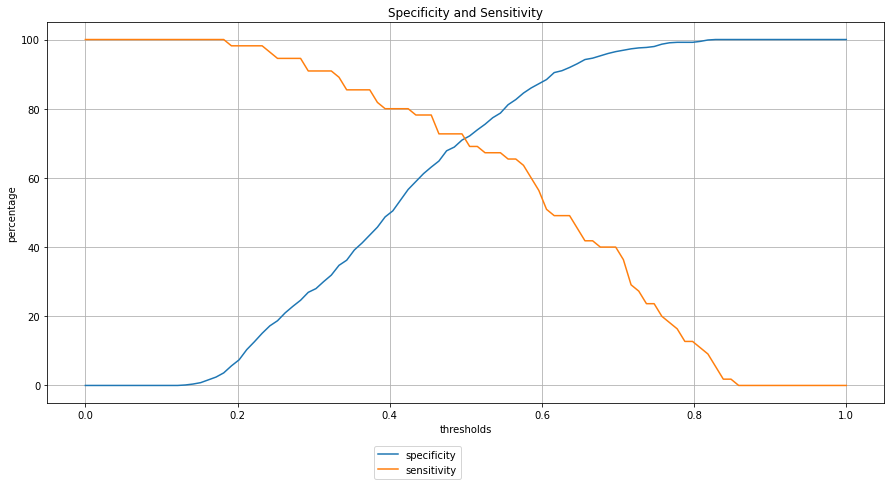

In [515]:
# https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663
# only select [:,1] == probabilities for the positive class ONLY
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


roc_values = []
specificities, sensitivities = [],[]

for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = np.ravel(metrics.confusion_matrix(y_true=val_y, y_pred=preds))
    tpr = tp/(tp+fn) #recall/sensitivity
    fpr = fp/(fp+tn)
    specificity = tn/(tn+fp) *100
    sensitivity = tp/(tp+fn) *100
     
    roc_values.append([tpr, fpr])
    specificities.append(specificity)
    sensitivities.append(sensitivity)

    

fig, ax = plt.subplots(figsize=(15,7))
ax.grid(True)

sns.lineplot(x=np.linspace(0, 1, 100),y=specificities, label="specificity", ax = ax)
sns.lineplot(x=np.linspace(0, 1, 100),y=sensitivities, label ="sensitivity", ax = ax)

ax.set_xlabel("thresholds")
ax.set_ylabel("percentage")
ax.legend(bbox_to_anchor=(0.5, -0.1))
ax.set_title("Specificity and Sensitivity")
fig.savefig("spec_sens")
plt.show()

In [478]:
should also check 

0.5162907268170426